In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

### Pipeline psuedo code
    n = look back window
    k = number of PCs to keep

    for each time point t:
        p = number of stocks in investable universe at time t
        Define an n x p feature matrix X (lagged returns)

        Perform PCA on X
        Keep the first k PCs in an n x k matrix Z

    for each stock s in the investable universe at time t:
        Define an n x 1 outcome vector y (future returns of stock s)
        Perform a linear regression of y on Z
        Predict y for stock s at time t+1

## Data Preparation

In [3]:
returns_monthly = pd.read_pickle("./Data/returns-monthly.pkl")
returns_monthly

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,9660J1,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.034290,-0.505618,-0.208625,-0.814073,-0.293528,-0.315632,-0.576403,0.010648,-0.693910,-0.338995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-28,0.455169,0.650143,-0.205743,0.109907,-0.067332,-0.032033,0.729168,0.595178,0.004846,0.410031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-31,0.355809,0.311451,0.285771,0.256536,0.117143,-0.215774,0.502729,0.055353,0.005520,-0.354091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-30,-0.243626,-0.159577,-0.878102,-0.222391,0.080013,-0.239431,-0.188944,-0.199850,-0.395150,-0.243304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-31,0.185911,0.112843,0.401598,0.335875,0.525889,-0.041198,0.863260,0.439779,0.595637,1.106905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,NaN,NaN,NaN,NaN,0.653127,NaN,-0.324973,NaN,NaN,NaN,...,-0.133998,0.695155,-0.045443,0.353482,-0.110210,1.086909,0.075012,0.472987,-0.196218,0.215045
2021-02-28,NaN,NaN,NaN,NaN,-0.156176,NaN,-0.042147,NaN,NaN,NaN,...,-0.152440,-0.772888,0.640719,-0.079415,0.325228,0.690940,0.722464,1.635837,1.562436,0.545335
2021-03-31,NaN,NaN,NaN,NaN,0.012640,NaN,-0.276290,NaN,NaN,NaN,...,-0.143479,0.102567,0.241327,-0.171112,-0.168559,-0.279081,0.512621,0.035363,-0.232262,0.073939


In [4]:
returns = pd.read_pickle("./Data/returns.pkl")
returns = returns.iloc[1:]

In [5]:
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

## Pipeline

In [6]:
def get_investable(t, n):
    """"Find stocks in investable universe at time t
    (stocks in the S&P500 that have prices recorded for the last n days)"""
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    n += 1
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index:t_index + n]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [7]:
def apply_PCA(inv, k):
    X = inv.iloc[1:, :]
    pca = PCA(n_components = k) 
    inv_scaled = StandardScaler().fit_transform(X)   
    principal_components = pca.fit_transform(inv_scaled)

    df = pd.DataFrame(data = principal_components)
    
    #For explained variance table
    components = pca.components_
    component_explained_var = pca.explained_variance_ratio_ * 100
    
    comp_names = ['PCA' + str(i) for i in range(1, len(component_explained_var) + 1)]

    pca_results = pd.DataFrame(data = component_explained_var, index = comp_names)
    pca_results.columns = ['Explained variance (%)']
    pca_results['Explained variance (%)'] = pca_results['Explained variance (%)'].round(2)
    
    return df

In [9]:
def define_y(inv, stock, n):
    y = inv[[stock]].iloc[:-1]
    
    return y

In [10]:
def train_test(X, y):
    X_train = X.iloc[1:, :]
    X_test = X.iloc[0:1, :]
    y_train = y.iloc[1:]
    y_test = y.iloc[0:1]
    
    return X_train, y_train, X_test, y_test

In [11]:
# Converts investable dataframe into 3D tensor for input into RNN fitting
# Eg. if investable_df has shape (52, 635), it is converted to a numpy array of shape (52, 1, 635)

def formatX(investable_df):
    train_values = []
    # Iterates through each day in investable df and appends feature values to train_values
    for i in range(len(investable_df.index)):
        train_values.append(investable_df.iloc[i].values)
    train_values = np.array(train_values) # converts to numpy array
    train_values = np.reshape(train_values, (train_values.shape[0], 1, train_values.shape[1])) # reshapes to 3-dimensional
    return train_values

In [12]:
# Formats output for a stock as a np array
# Takes in a stock, a date, and a number of rows to look back on and formats the output values as a numpy array
# Eg. formatY(stockX, Feb.25, 80) outputs the returns for stockX starting from 80 days before Feb.25 up to Feb.25

def formatY(y):
    return np.array(y)[:, 0]

In [13]:
from keras.callbacks import EarlyStopping

def model_fit(X_train, y_train):
    
    convertedX = formatX(X_train)
    convertedY = formatY(y_train)
    
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(convertedX.shape[1], convertedX.shape[2]), activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    early_stopping = EarlyStopping(monitor="val_loss", patience=5)
    
    # Fits model on formatted inputs and outputs
    model.fit(convertedX, convertedY, epochs=100, 
              batch_size=16, verbose=0, validation_split=0.2,
              callbacks=[early_stopping])
    
    return model

In [14]:
def model_predict(model, X_test):
    convertedX = formatX(X_test)
    yhat = model.predict(convertedX)
    
    return yhat

In [15]:
def predict_returns(t, n, k, model, refit=True):
    inv = get_investable(t, n)
    X = apply_PCA(inv, k)
    
    returns_t = pd.DataFrame(index = inv.columns, columns = ['Pred', 'Actual'])
    
    for stock in inv.columns:
        y = define_y(inv, stock, n)
        X_train, y_train, X_test, y_test = train_test(X, y)
        
        if refit:
            model = model_fit(X_train, y_train)
            
        yhat = model_predict(model, X_test)[0][0]
        returns_t['Pred'].loc[stock] = yhat
        returns_t['Actual'].loc[stock] = y_test.values[0][0]
    
    return returns_t, model

In [16]:
def rank_stocks(returns, num_stocks):
    pred_returns = returns.sort_values(by = 'Pred', ascending = False)
    topn = pred_returns.head(num_stocks)
    botn = pred_returns.tail(num_stocks)
    
    return topn, botn

In [17]:
def portfolio_return(topn, botn, returns):
    return_t = topn['Actual'].mean() - botn['Actual'].mean()
    
    return return_t

In [18]:
def pipeline(n, k, num_stocks):

    time_range = returns.loc['2015':'2021'].index
    
    for i in range(len(time_range)):
        if time_range[i] in returns_monthly.index:
            time_range = time_range[i:]
            break
    
    portfolio = pd.DataFrame(index = time_range, columns = ['Portfolio Return'])
    current_model = Sequential()
    
    count = 0
    for t in time_range[:-1]:
        if t in returns_monthly.index:
            pred_actual, current_model = predict_returns(t, n, k, current_model, refit=True)
        else:
            pred_actual, current_model = predict_returns(t, n, k, current_model, refit=False)
        
        topn, botn = rank_stocks(pred_actual, num_stocks)
        return_t = portfolio_return(topn, botn, pred_actual)
        t_index = time_range.get_loc(t) + 1
        portfolio['Portfolio Return'].loc[time_range[t_index]] = return_t
        count +=1
        print(f'{(count/len(time_range))*100:.2f}% complete')
        
    portfolio['Portfolio Return'] = portfolio['Portfolio Return'].astype("float")
    
    return portfolio

In [19]:
portfolio = pipeline(50, 20, 5)

0.06% complete
0.13% complete
0.19% complete
0.26% complete
0.32% complete
0.39% complete
0.45% complete
0.52% complete
0.58% complete
0.64% complete
0.71% complete
0.77% complete
0.84% complete
0.90% complete
0.97% complete
1.03% complete
1.09% complete
1.16% complete
1.22% complete
1.29% complete
1.35% complete
1.42% complete
1.48% complete
1.55% complete
1.61% complete
1.67% complete
1.74% complete
1.80% complete
1.87% complete
1.93% complete
2.00% complete
2.06% complete
2.12% complete
2.19% complete
2.25% complete
2.32% complete
2.38% complete
2.45% complete
2.51% complete
2.58% complete
2.64% complete
2.70% complete
2.77% complete
2.83% complete
2.90% complete
2.96% complete
3.03% complete
3.09% complete
3.16% complete
3.22% complete
3.28% complete
3.35% complete
3.41% complete
3.48% complete
3.54% complete
3.61% complete
3.67% complete
3.73% complete
3.80% complete
3.86% complete
3.93% complete
3.99% complete
4.06% complete
4.12% complete
4.19% complete
4.25% complete
4.31% comp

27.75% complete
27.82% complete
27.88% complete
27.95% complete
28.01% complete
28.07% complete
28.14% complete
28.20% complete
28.27% complete
28.33% complete
28.40% complete
28.46% complete
28.53% complete
28.59% complete
28.65% complete
28.72% complete
28.78% complete
28.85% complete
28.91% complete
28.98% complete
29.04% complete
29.10% complete
29.17% complete
29.23% complete
29.30% complete
29.36% complete
29.43% complete
29.49% complete
29.56% complete
29.62% complete
29.68% complete
29.75% complete
29.81% complete
29.88% complete
29.94% complete
30.01% complete
30.07% complete
30.14% complete
30.20% complete
30.26% complete
30.33% complete
30.39% complete
30.46% complete
30.52% complete
30.59% complete
30.65% complete
30.71% complete
30.78% complete
30.84% complete
30.91% complete
30.97% complete
31.04% complete
31.10% complete
31.17% complete
31.23% complete
31.29% complete
31.36% complete
31.42% complete
31.49% complete
31.55% complete
31.62% complete
31.68% complete
31.75% c

60.79% complete
60.85% complete
60.91% complete
60.98% complete
61.04% complete
61.11% complete
61.17% complete
61.24% complete
61.30% complete
61.37% complete
61.43% complete
61.49% complete
61.56% complete
61.62% complete
61.69% complete
61.75% complete
61.82% complete
61.88% complete
61.94% complete
62.01% complete
62.07% complete
62.14% complete
62.20% complete
62.27% complete
62.33% complete
62.40% complete
62.46% complete
62.52% complete
62.59% complete
62.65% complete
62.72% complete
62.78% complete
62.85% complete
62.91% complete
62.97% complete
63.04% complete
63.10% complete
63.17% complete
63.23% complete
63.30% complete
63.36% complete
63.43% complete
63.49% complete
63.55% complete
63.62% complete
63.68% complete
63.75% complete
63.81% complete
63.88% complete
63.94% complete
64.01% complete
64.07% complete
64.13% complete
64.20% complete
64.26% complete
64.33% complete
64.39% complete
64.46% complete
64.52% complete
64.58% complete
64.65% complete
64.71% complete
64.78% c

93.82% complete
93.88% complete
93.95% complete
94.01% complete
94.08% complete
94.14% complete
94.20% complete
94.27% complete
94.33% complete
94.40% complete
94.46% complete
94.53% complete
94.59% complete
94.66% complete
94.72% complete
94.78% complete
94.85% complete
94.91% complete
94.98% complete
95.04% complete
95.11% complete
95.17% complete
95.24% complete
95.30% complete
95.36% complete
95.43% complete
95.49% complete
95.56% complete
95.62% complete
95.69% complete
95.75% complete
95.81% complete
95.88% complete
95.94% complete
96.01% complete
96.07% complete
96.14% complete
96.20% complete
96.27% complete
96.33% complete
96.39% complete
96.46% complete
96.52% complete
96.59% complete
96.65% complete
96.72% complete
96.78% complete
96.84% complete
96.91% complete
96.97% complete
97.04% complete
97.10% complete
97.17% complete
97.23% complete
97.30% complete
97.36% complete
97.42% complete
97.49% complete
97.55% complete
97.62% complete
97.68% complete
97.75% complete
97.81% c

In [20]:
portfolio.dropna(inplace = True)

In [21]:
portfolio

,Portfolio Return
date,
2015-04-01,-0.944199
2015-04-02,0.348428
2015-04-06,0.075472
2015-04-07,-0.711858
2015-04-08,-0.427156
...,...
2021-05-24,-0.601513
2021-05-25,1.410525
2021-05-26,0.721430


In [22]:
portfolio.to_csv('results/LSTM.csv')

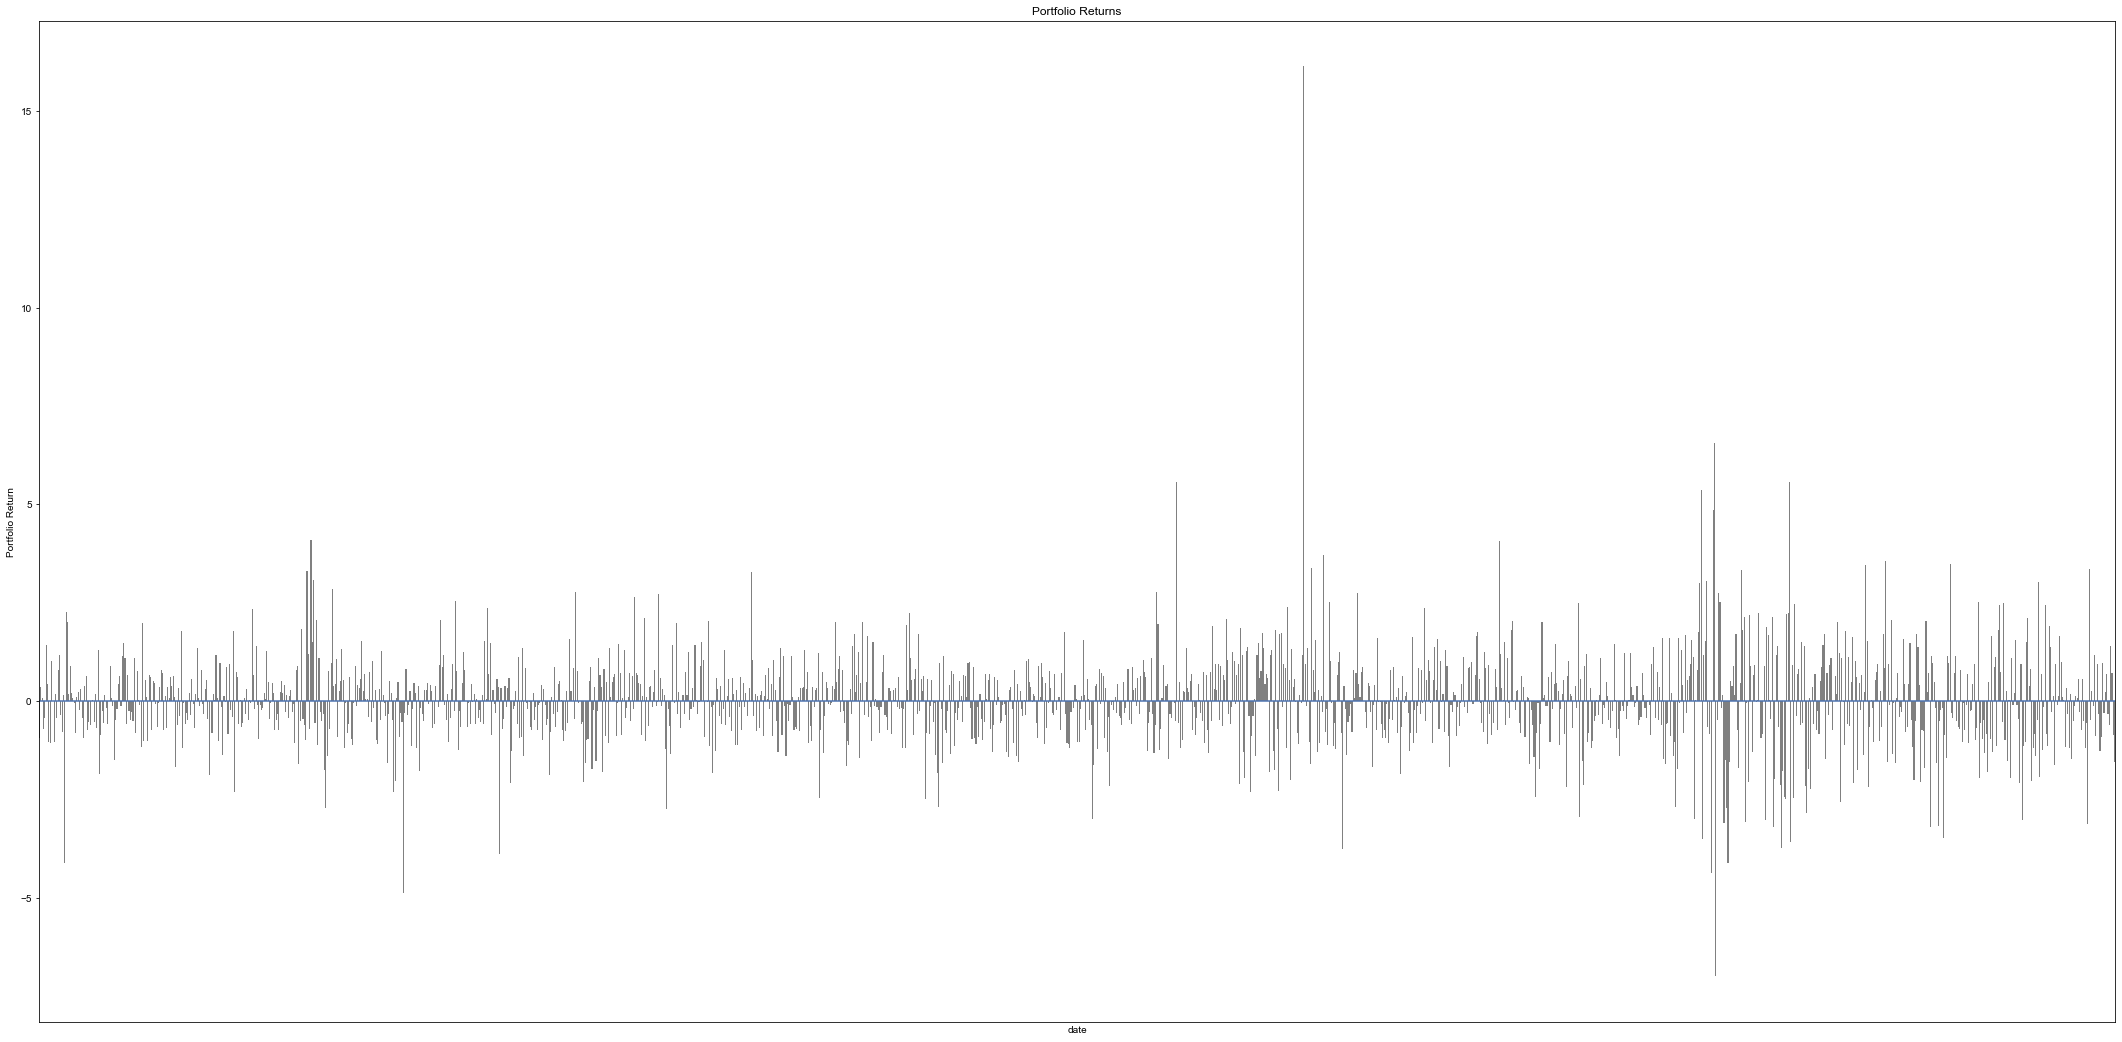

In [23]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

fig, axes = plt.subplots(figsize=(30,15))
sns.barplot(x = portfolio.index, y = 'Portfolio Return', data = portfolio, color = 'grey')

axes.xaxis.set_major_locator(mdates.YearLocator())
axes.xaxis.set_minor_locator(mdates.MonthLocator())

ticklabels = [item.strftime('%Y') for item in portfolio.resample('Y').mean().index.to_period('Y')]

axes.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.xticks(rotation = 'vertical')
axes.set_title('Portfolio Returns')

sns.set(font_scale=2)
plt.axhline(0)

plt.tight_layout()


plt.show()

In [24]:
avg_return = portfolio['Portfolio Return'].mean()
print(f'Average return is {avg_return:.2f} %')

Average return is 0.02 %


In [25]:
rolling_avg = pd.DataFrame(data = portfolio['Portfolio Return'].rolling(252).mean())

In [26]:
rolling_avg.dropna(inplace = True)

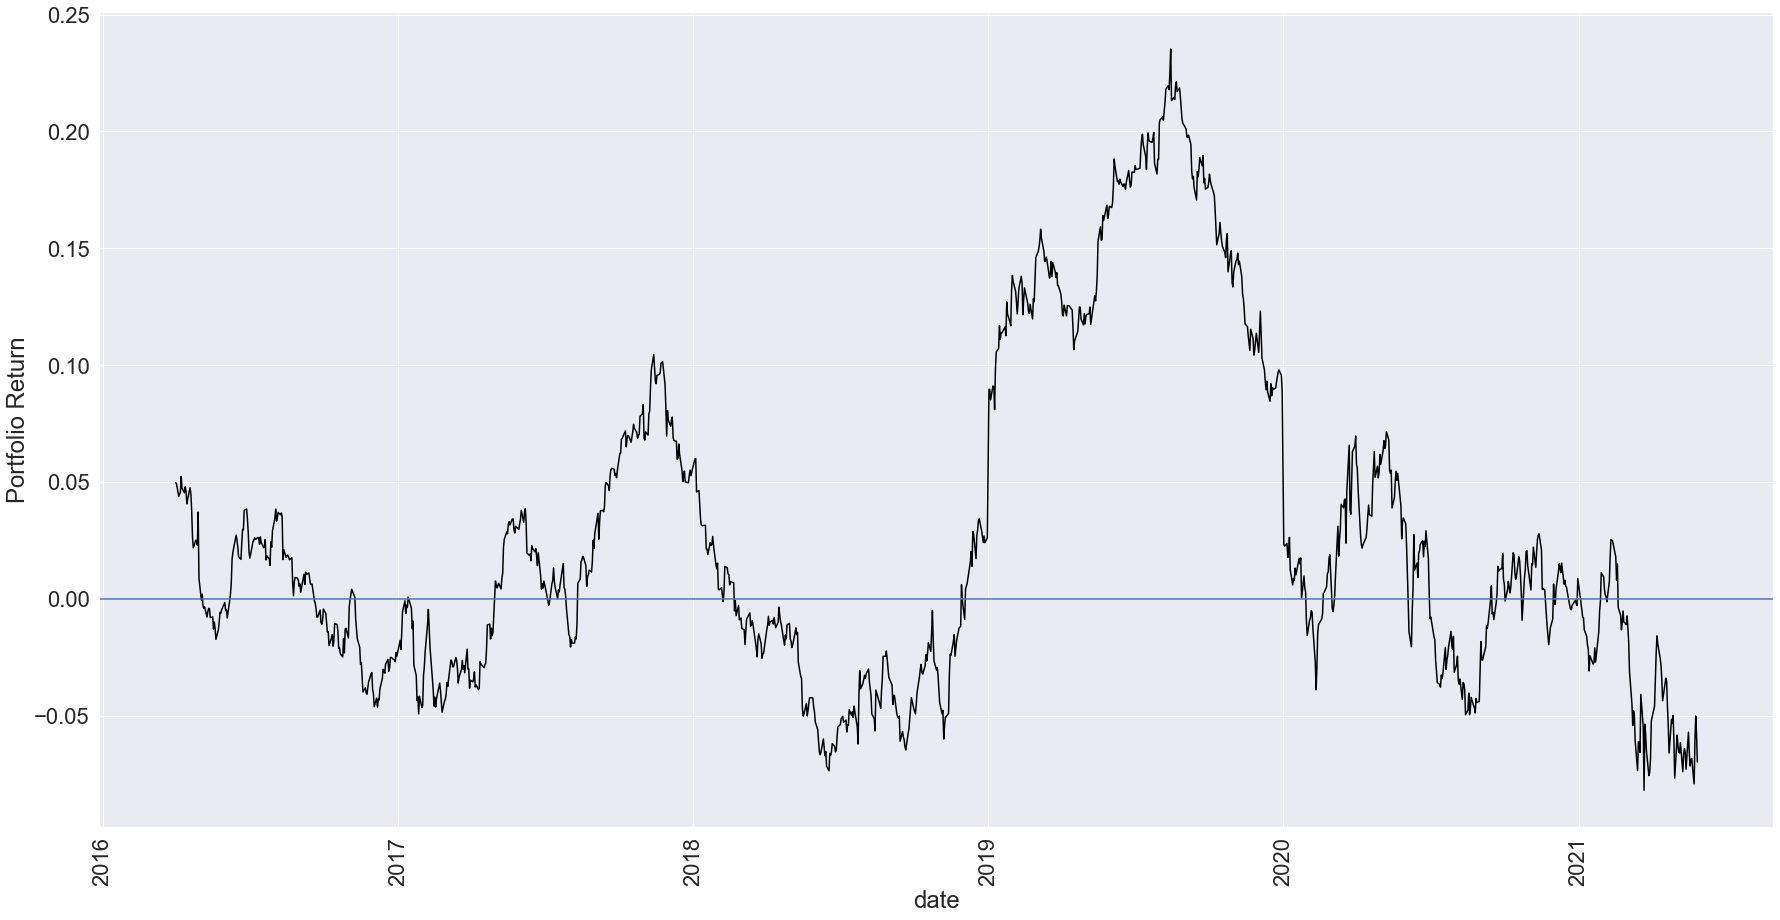

In [27]:
fig, axes = plt.subplots(figsize=(30,15))
sns.lineplot(x = rolling_avg.index, y = 'Portfolio Return', data = rolling_avg, color = 'black')
plt.xticks(rotation = 'vertical')
plt.axhline(0)